In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# Data

In [3]:
# Read the data
data_raw = pd.read_csv('vgsales.csv', index_col='Rank')
data_raw.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
Rank,,,,,,,,,,
1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [4]:
columns = ['Genre', 'Year', 'Platform', "Publisher", 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
categorical_columns = ["Platform", "Publisher"]
# Separate categorical variables

data = data_raw.loc[:, data_raw.columns.isin(columns)]

# Delete all rows with missing and duplicates values
data = data.dropna()
data = data.drop_duplicates()

# For all columns with factor variables, create dummy variables,
# in this case these are columns Platform, Publisher
data = pd.get_dummies(data, columns=categorical_columns)

# Shuffle before separating data
data = data.sample(frac=1)

data.head()

,Year,Genre,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Platform_2600,Platform_3DO,Platform_3DS,Platform_DC,...,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_dramatic create,Publisher_fonfun,Publisher_iWin,Publisher_id Software,Publisher_imageepoch Inc.,Publisher_inXile Entertainment,"Publisher_mixi, Inc",Publisher_responDESIGN
Rank,,,,,,,,,,,,,,,,,,,,,
3635,2005.0,Action,0.34,0.01,0.15,0.06,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
918,2005.0,Shooter,0.89,0.69,0.09,0.21,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6093,2012.0,Action,0.12,0.12,0.00,0.05,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15666,2011.0,Role-Playing,0.00,0.00,0.02,0.00,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11382,2009.0,Racing,0.04,0.03,0.00,0.01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train & test preparation

In [5]:
test_size = .33
tts_random_state = 1

In [6]:
# Select the target feature and remove it from the data, on the basis of which the classifier will be trained
data["Genre"] = np.where(data["Genre"] == 'Sports', 1, 0)

y = data["Genre"]

X = data.loc[:, data.columns != "Genre"]
scaler = StandardScaler()
# Scale the sample
X_scaled = scaler.fit_transform(X)

# Separate data into training and test
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=tts_random_state)

# Train

### Decision tree

In [7]:
train_random_state = 241

In [8]:
# In this task i use "tqdm" library, it helps to follow the learning process
report_array = []
for tree_depth in tqdm(range(1, 30)):
    tree = DecisionTreeClassifier(random_state=train_random_state, max_depth=tree_depth)
    tree = tree.fit(x_train, y_train)
    
    train_accuracy = tree.score(x_train, y_train).round(3)
    test_accuracy = tree.score(x_test, y_test).round(3)
    
    report_array.append([tree_depth, train_accuracy, test_accuracy])

  0%|          | 0/29 [00:00<?, ?it/s]

## Plot experiment result:

<AxesSubplot:xlabel='tree_depth'>

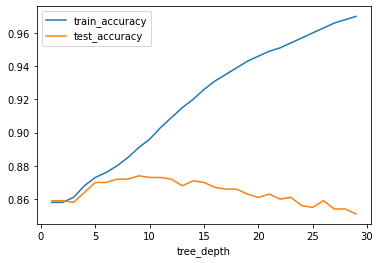

In [10]:
report_df = pd.DataFrame(report_array, columns=["tree_depth", "train_accuracy", "test_accuracy"])
report_df.plot(x="tree_depth", y=["train_accuracy", "test_accuracy"])
# Build a graph of the dependence of prediction accuracy on the depth of the decision tree
# for samples of test and general data

Note that with an increase in the depth of the tree, the accuracy of the prediction built on the test set decreases.

### Estimate tree with best depth

In [11]:
# Train a classifier with the best depth found
best_depth = report_df.iloc[report_df["test_accuracy"].argmax(), :]["tree_depth"]
best_tree = DecisionTreeClassifier(random_state=train_random_state, max_depth=5)
best_tree = best_tree.fit(x_train, y_train)

In [12]:
# Evaluate the accuracy of the classifier using the precision, recall and f1 metrics on the test sample
report = classification_report(y_test, best_tree.predict(x_test), target_names=['Not sport', 'Sport'])
print("Depth-optimized tree:\n", report)

Depth-optimized tree:
               precision    recall  f1-score   support

   Not sport       0.88      0.98      0.93      4531
       Sport       0.62      0.20      0.30       742

    accuracy                           0.87      5273
   macro avg       0.75      0.59      0.62      5273
weighted avg       0.84      0.87      0.84      5273



We see that the accuracy value for this classifier is quite large - 87%. This is due to the fact that the depth of the tree
was selected in accordance with the accuracy metric. Also, the model well defines objects belonging to the class Genre = 'Sports', precision = 55%, as well as objects that do not belong to this class - in this case, the value of the metrics is not less than 89%.

### Feature_importances

Let's see what features were important in the decision tree classification. Let's choose those of them for which the percentage of importance, for example, is more than 4%.

In [13]:
importance_level = 0.04

<Figure size 432x288 with 0 Axes>

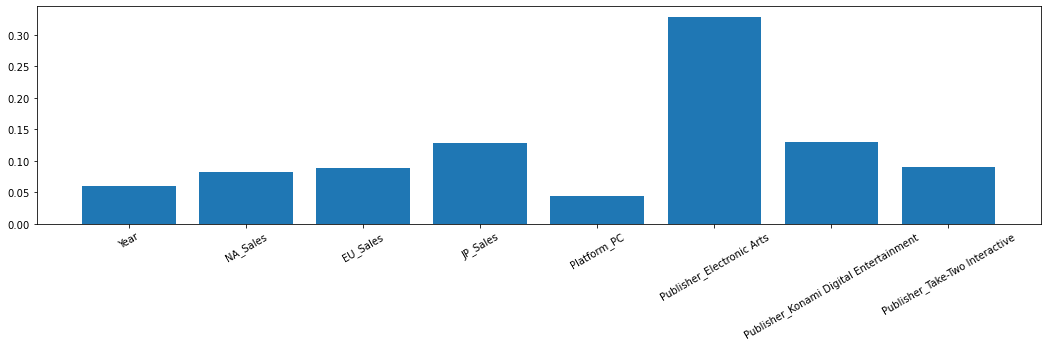

In [40]:
feature_importances = best_tree.feature_importances_
significant_features = [i for i in range(0, len(feature_importances)) if feature_importances[i] > importance_level]
rs = [i for i in feature_importances if i > importance_level]
data2 = X.iloc[:,significant_features]

fig = plt.figure()
plt.figure(figsize=(18, 4))
plt.bar(data2.columns, rs)
plt.xticks(rotation=30)
plt.show()

The important features were the year of release of the game, sales in North America, Japan and Europe. Also owned by Electronic Arts, Konami Digital Entertainment and Take-Two Interactive.

Let's try to picture the distribution by class. Orange dots - Sport class, blue dots - Not Sport

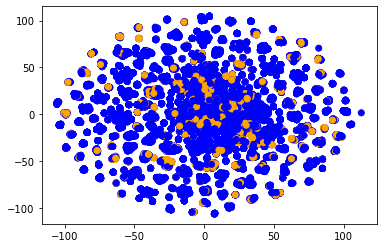

In [22]:
tsne = TSNE(random_state=17)
tsne_representation = tsne.fit_transform(X_scaled)

plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
            c=y.map({0: 'blue', 1: 'orange'}))

### Tree visualization

Draw the final tree

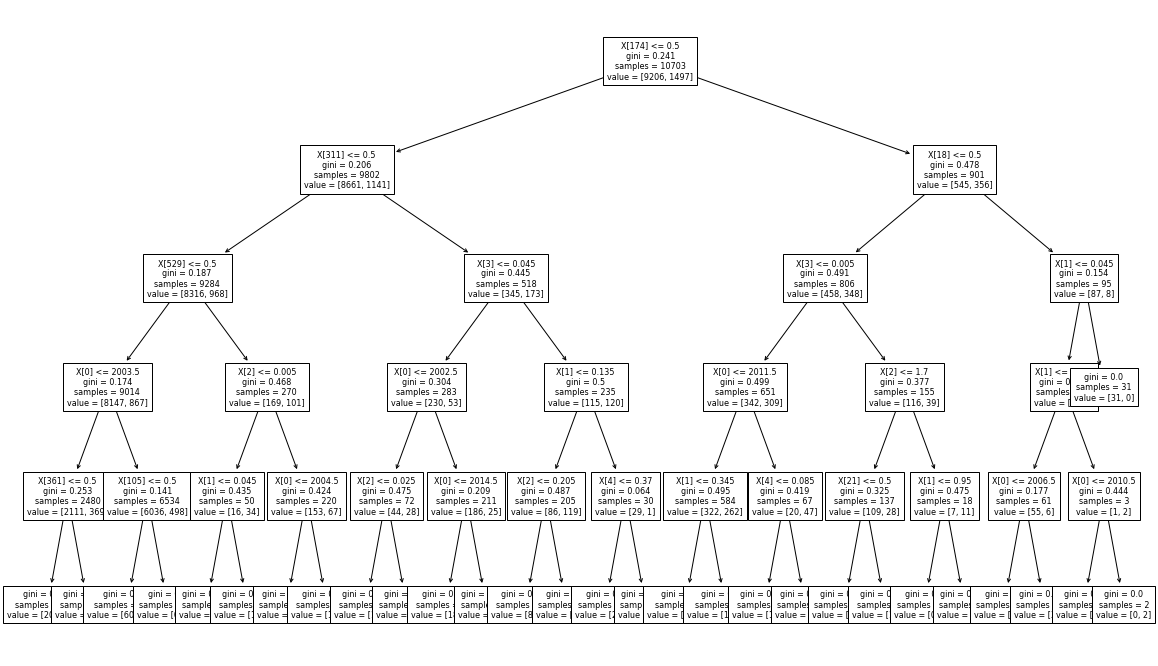

In [101]:
plt.figure(figsize =(20,12))
plot_tree(best_tree, fontsize = 8)
plt.show()

### Сlassification with random forest

In [112]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': range(50, 501, 50),
    'max_depth' : [2, 5, 10, 15, 20],
    'random_state': [train_random_state],
}
scoring = ['accuracy', 'f1', 'precision', 'recall']

RFC = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring=scoring, refit='f1') 
RFC.fit(X, y)

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar


 The best parameters:
 {'max_depth': 20, 'n_estimators': 100, 'random_state': 241}


In [113]:
print("\n The best parameters:\n",RFC.best_params_)


 The best parameters:
 {'max_depth': 20, 'n_estimators': 100, 'random_state': 241}


In [114]:
param_grid = {
    'n_estimators': range(70, 131, 10),
    'max_depth' : [15, 20, 25],
    'random_state': [train_random_state],
}
scoring = ['accuracy', 'f1', 'precision', 'recall']

RFC1 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring=scoring, refit='f1') 
RFC1.fit(X, y)

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 20, 25],
                         'n_estimators': range(70, 131, 10),
                         'random_state': [241]},
             refit='f1', scoring=['accuracy', 'f1', 'precision', 'recall'])

In [115]:
print("\n The best parameters:\n",RFC1.best_params_)


 The best parameters:
 {'max_depth': 25, 'n_estimators': 110, 'random_state': 241}


In [116]:
param_grid = {
    'n_estimators': range(105, 116),
    'max_depth' : [15, 20, 25, 30],
    'random_state': [train_random_state],
}
scoring = ['accuracy', 'f1', 'precision', 'recall']

RFC2 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, scoring=scoring, refit='f1') 
RFC2.fit(X, y)

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Elizaveta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWar

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [15, 20, 25, 30],
                         'n_estimators': range(105, 116),
                         'random_state': [241]},
             refit='f1', scoring=['accuracy', 'f1', 'precision', 'recall'])

In [117]:
print("\n The best parameters:\n",RFC2.best_params_)


 The best parameters:
 {'max_depth': 30, 'n_estimators': 108, 'random_state': 241}


The best random forest classifier is obtained with the number of trees - 108 and their maximum depth - 30

In [119]:
# Let's evaluate the accuracy of the classifier using the precision, recall and f1 metrics on the test sample
best_RFC = RFC2.best_estimator_
best_RFC.fit(x_train, y_train)

report = classification_report(y_test, best_RFC.predict(x_test), target_names=['Not sport', 'Sport'])
print("Best RFC:\n", report)

Best RFC:
               precision    recall  f1-score   support

   Not sport       0.87      0.99      0.93      4509
       Sport       0.74      0.16      0.26       764

    accuracy                           0.87      5273
   macro avg       0.81      0.58      0.60      5273
weighted avg       0.85      0.87      0.83      5273



For this classifier, the accuracy value is also high - 87%. It works well for determining objects of the Not Sport class, the values of all metrics are not lower than 87%. Also, the value of the precision metric for the Sports class is high - 74%, which means that the classifier rarely designates objects of other classes as the Sport class. In comparison with the decision tree by the f1 metric, the random forest performs worse, because with equal values ​​of the metric on the Not Sport class and the value of accuracy, the f1 metric in the random forest is 9% less. This may be because a lot of parameters are introduced, due to the introduction of dummy variables. It can be concluded that the classifier on one tree works more efficiently than the classifier on several.